# Informational Connectivity
* Intro [1]
  * Brain regions are organized into functional networks in which different regions have distinct functional roles, and information is transformed from brain region to brain region to implement the computations that support cognition.
  * Therefore, to fully understand information processing in the brain, it is necessary to study regional interactions.
  * With the importance of brain networks and multivoxel representations in perceptual and cognitive functions, understanding how regional multivoxel information interacts at the network level has great potential for shedding further light on how the brain implements cognition.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import nilearn.image
import nilearn.plotting
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

/Users/eyshin/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/eyshin/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/eyshin/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Data Loading
* Description
  * GA project
  * total 25 subjects
  * Early vs. Late
  * Practiced mapping

In [2]:
subj_list = ['GA01', 'GA02', 'GA05', 'GA07', 'GA08', 
             'GA11', 'GA12', 'GA13', 'GA14', 'GA15',
             'GA18', 'GA19', 'GA20', 'GA21', 'GA23', 
             'GA26', 'GA27', 'GA28', 'GA29', 'GA30', 
             'GA31', 'GA32', 'GA33', 'GA34', 'GA35']

img_dir = '/Volumes/clmnlab/GA/MVPA/LSS_pb02_short_duration/data/'
behav_dir = '/Volumes/clmnlab/GA/MVPA/LSS_pb02/behaviors/'

In [3]:
# load beta img

imgs = {}

for subj in subj_list:
    for run in (1, 2, 3):
        subj_id = subj
        imgs[subj_id, run] = nilearn.image.load_img(img_dir + 'betasLSS.%s.r%02d.nii.gz' % (subj_id, run))
        
        subj_id = subj.replace('GA', 'GB')
        imgs[subj_id, run] = nilearn.image.load_img(img_dir + 'betasLSS.%s.r%02d.nii.gz' % (subj_id, run))
    
    print(subj, end='\r')

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


## ROI selection
* Fan ROI
  * Seed: left upper-limb motor area
  * Others: visual areas

In [4]:
cluster_df = pd.read_csv('/Volumes/clmnlab/GA/fmri_data/masks/Fan/fan_cluster_net.tsv', 
                         delimiter='\t', index_col=0)
cluster_df.head()

,name,name_short,full_name,full_name_short,dat_index,cluster_16,cluster_9,network_name,region_name,pain_cluster_name,anat_cluster_name,laterality
0,SFG_L_7_1 (8m),SFG-L (8m),"Lt. superior frontal gyrus (BA8, medial)","Lt. superior frontal gyrus (BA8, medial)",1,Frontoparietal,Frontoparietal,FPN,SFG,None,Fr,left
1,SFG_R_7_1 (8m),SFG-R (8m),"Rt. superior frontal gyrus (BA8, medial)","Rt. superior frontal gyrus (BA8, medial)",2,Frontoparietal,Frontoparietal,FPN,SFG,None,Fr,right
2,SFG_L_7_2 (8dl),SFG-L (8dl),"Lt. superior frontal gyrus (BA8, dorsolateral)","Lt. superior frontal gyrus (BA8, dorsolateral)",3,Frontoparietal,Frontoparietal,FPN,SFG,None,Fr,left
3,SFG_R_7_2 (8dl),SFG-R (8dl),"Rt. superior frontal gyrus (BA8, dorsolateral)","Rt. superior frontal gyrus (BA8, dorsolateral)",4,Frontoparietal,Frontoparietal,FPN,SFG,None,Fr,right
4,SFG_L_7_3 (9l),SFG-L (9l),"Lt. superior frontal gyrus (BA9, lateral)","Lt. superior frontal gyrus (BA9, lateral)",5,Default,Default,DMN,SFG,None,Fr,left


In [5]:
seed_idx = 57

roi_df = cluster_df[cluster_df['cluster_16'] == 'visual (occipital)']
roi_idxs = list(roi_df['dat_index'])
roi_names = list(roi_df['full_name_short'])

# load roi image files
seed_img = nilearn.image.load_img(
    '/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%03d.nii'%(seed_idx))

roi_imgs = [nilearn.image.load_img(
                '/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%03d.nii'%(idx)) 
            for idx in roi_idxs]

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


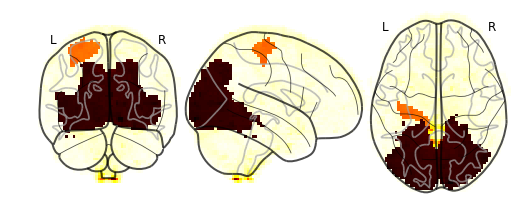

In [6]:
# orange color = seed roi, black color = visual areas

nilearn.plotting.plot_glass_brain(
    nilearn.image.math_img(formula='A + np.max(B, axis=3) * 2 + np.mean(C, axis=3) / 1000', 
                           A=seed_img, B=roi_imgs, C=imgs['GA01', 1]))

In [7]:
# nilearn's masking is too slow for me, so I wrote this simple masking function

def fast_masking(img, roi):
    img_data = img.get_data()
    roi_mask = roi.get_data().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T

In [8]:
# img to masked data

data = {}

for (subj, run), value in imgs.items():
    for roi_idx, roi_img in zip([seed_idx] + roi_idxs, [seed_img] + roi_imgs):
        data[subj, run, roi_idx] = fast_masking(value, roi_img)[1:97, :]

## Processing informational time-series

In [9]:
# targets (remove first trial, use second ~ last trials)

with open(behav_dir + 'targetID.txt', 'r') as file:
    labels = file.readlines()
    labels = [int(l.strip()) for l in labels[1:97]]

In [10]:
def proc_informational_times_series(estimator, score_func):
    probs = {}
    
    for subj in subj_list:
        for run in (1, 2, 3):
            for roi_idx, roi_img in zip([seed_idx] + roi_idxs, [seed_img] + roi_imgs):
                subj_id = subj
                
                train_X = np.concatenate([data[subj_id, r, roi_idx] for r in (1, 2, 3) if r != run])
                train_y = labels + labels

                test_X = data[subj_id, run, roi_idx]
                test_y = labels

                estimator.fit(train_X, train_y)
                probs[subj_id, run, roi_idx] = score_func(estimator, test_X, test_y)
                
                subj_id = subj.replace('GA', 'GB')
                
                train_X = np.concatenate([data[subj_id, r, roi_idx] for r in (1, 2, 3) if r != run])
                train_y = labels + labels

                test_X = data[subj_id, run, roi_idx]
                test_y = labels

                estimator.fit(train_X, train_y)
                probs[subj_id, run, roi_idx] = score_func(estimator, test_X, test_y)
                
    return probs

### LDA classifier probability

In [11]:
def prob_estimator(estimator, test_X, test_y):
    probs = estimator.predict_proba(test_X)
    preds = estimator.predict(test_X) == test_y
    
    class_idx = {c:i for i, c in enumerate(estimator.classes_)}
    results = [p[class_idx[t]] for t, p in zip(test_y, probs)]
    return np.array(results)

In [12]:
# get some timeseries

lda_probs = proc_informational_times_series(LinearDiscriminantAnalysis(), prob_estimator)

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


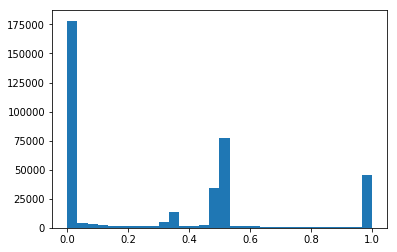

In [13]:
# histogram of probabilities

plt.hist(np.array([np.array(v) for v in lda_probs.values()]).ravel(), bins=30)
plt.show()

### SVC classifier probability

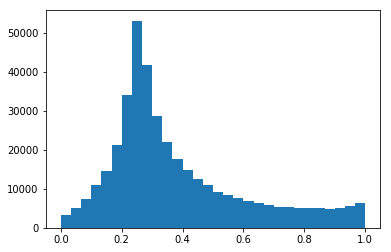

In [14]:
# it takes long long time

svc_probs = proc_informational_times_series(SVC(kernel='linear', probability=True), prob_estimator)

plt.hist(np.array([np.array(v) for v in svc_probs.values()]).ravel(), bins=30)
plt.show()

### LDA distance from decision boundary [2] (euclidean)

In [15]:
def dist_estimator(estimator, test_X, test_y):
    class_idx = {c:i for i, c in enumerate(estimator.classes_)}
    results = []
    
    y = estimator.decision_function(test_X)
    w_norm = np.linalg.norm(estimator.coef_)
    results = [(z/w_norm)[class_idx[t]] for z, t in zip(y, test_y)]
    
    return np.array(results)

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


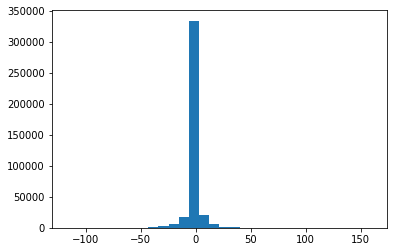

In [16]:
lda_dists = proc_informational_times_series(LinearDiscriminantAnalysis(), dist_estimator)

plt.hist(np.array([np.array(v) for v in lda_dists.values()]).ravel(), bins=30)
plt.show()

### SVC distance from decision boundary

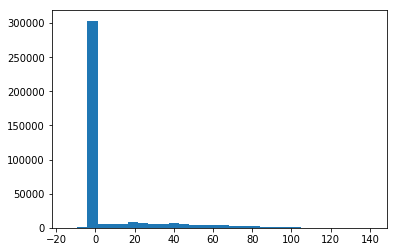

In [17]:
svc_dists = proc_informational_times_series(SVC(kernel='linear'), dist_estimator)

plt.hist(np.array([np.array(v) for v in svc_dists.values()]).ravel(), bins=30)
plt.show()

### Correlation-based classifier 
* Methods [3]
  * Calculate the Pearson correlation coefficient between the (i) vector of voxel activation values for that time-point (i.e., its activity pattern) and (ii) vector of mean voxel activation values for the time-point's condition in the training data (i.e., the prototypical activity pattern for the condition). Fisher-transform to z-score.
  * Calculate the Pearson correlation coefficient between the (i) vector of voxel activation values for that time-point (i.e., its activity pattern) and (ii) vector of mean voxel activation values for each alternate condition in the training data (i.e., the prototypical activity patterns for the rival conditions).
  * Identify the highest correlation from step 2 (i.e., the highest similarity to an “incorrect” condition). Fisher-transform to z-score.
  * Multi-voxel Pattern Discriminability = Step 1 − Step 3 (i.e., Relationship to condition's prototypical pattern minus Relationship to the most similar incorrect condition).


In [18]:
class CorrealtionBasedClassifier:
    # It is implemented only what I need
    
    def __init__(self):
        self.mean_activations = []
        self.classes_ = []
    
    def fit(self, X, y):
        self.classes_ = sorted(set(y))
        self.mean_activations = []
        
        #scaler = StandardScaler()
        #X = scaler.fit_transform(X)
        y = np.array(y)
        
        for c in self.classes_:
            self.mean_activations.append(np.mean(X[y==c, :], axis=0))
    
    def predict_corr(self, X, debug=False):
        corr_matrix = np.corrcoef(np.concatenate((X, self.mean_activations)))
        
        if debug:
            plt.figure(figsize=(7, 7))
            plt.matshow(corr_matrix, fignum=1)
        
        return corr_matrix[:-4, -4:]

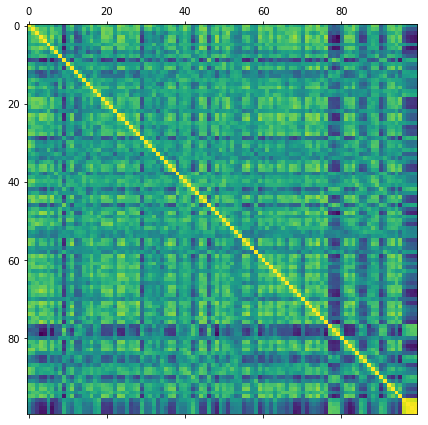

In [19]:
# test code

estimator = CorrealtionBasedClassifier()

run = 1
train_X = np.concatenate([data['GA01', r, seed_idx] for r in (1, 2, 3) if r != run])
train_y = labels + labels

test_X = data['GA01', run, seed_idx]
test_y = labels

estimator.fit(train_X, train_y)
_ = estimator.predict_corr(test_X, debug=True)

In [20]:
def corr_estimator(estimator, X, y):    
    class_idx = {c:i for i, c in enumerate(estimator.classes_)}
    
    corrs = estimator.predict_corr(X)
    
    step1 = []
    step3 = []
    
    for t, c in zip(y, corrs):
        args = np.argsort(c)[::-1]
        step1.append(c[class_idx[t]])
        
        if class_idx[t] == args[0]:
            step3.append(c[args[1]])
        else:
            step3.append(c[args[0]])
        
    scaler = StandardScaler()
    step1 = scaler.fit_transform(np.array(step1).reshape(-1, 1))
    step3 = scaler.fit_transform(np.array(step3).reshape(-1, 1))
        
    return step1 - step3

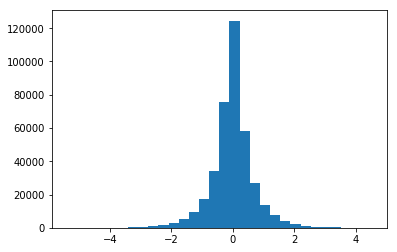

In [21]:
corr_corrs = proc_informational_times_series(CorrealtionBasedClassifier(), corr_estimator)

plt.hist(np.array([np.array(v) for v in corr_corrs.values()]).ravel(), bins=30)
plt.show()

## Run informational connectivity

In [22]:
def calc_corr_coefficient(result_dict):
    early_coefs = {}
    late_coefs = {}
    
    for roi_idx in roi_idxs:
        for subj in subj_list:
            subj_id = subj
            coefs = [
                np.corrcoef(result_dict[subj_id, 1, roi_idx].reshape(-1), result_dict[subj_id, 1, seed_idx].reshape(-1))[1, 0],
                np.corrcoef(result_dict[subj_id, 2, roi_idx].reshape(-1), result_dict[subj_id, 2, seed_idx].reshape(-1))[1, 0],
                np.corrcoef(result_dict[subj_id, 3, roi_idx].reshape(-1), result_dict[subj_id, 3, seed_idx].reshape(-1))[1, 0],
            ]
            early_coefs[subj, roi_idx] = np.mean(coefs)
            
            subj_id = subj.replace('GA', 'GB')
            coefs = [
                np.corrcoef(result_dict[subj_id, 1, roi_idx].reshape(-1), result_dict[subj_id, 1, seed_idx].reshape(-1))[1, 0],
                np.corrcoef(result_dict[subj_id, 2, roi_idx].reshape(-1), result_dict[subj_id, 2, seed_idx].reshape(-1))[1, 0],
                np.corrcoef(result_dict[subj_id, 3, roi_idx].reshape(-1), result_dict[subj_id, 3, seed_idx].reshape(-1))[1, 0],
            ]
            late_coefs[subj, roi_idx] = np.mean(coefs)
            
    return early_coefs, late_coefs

In [23]:
early, late = calc_corr_coefficient(corr_corrs)

In [24]:
early['GA05', 105], late['GA05', 105]

(0.11621820944435189, 0.372321546262042)

In [25]:
roi_coords = [nilearn.plotting.find_parcellation_cut_coords(img)[0] for img in [seed_img] + roi_imgs]
roi_coords = np.array(roi_coords)
#roi_coords

In [34]:
def mean_correlation_matrix(corr_coefs):
    matrix = np.zeros((len(roi_idxs)+1, len(roi_idxs)+1))
    
    for i, roi_idx in enumerate(roi_idxs):
        matrix[0, i+1] = np.mean([corr_coefs[subj, roi_idx] for subj in subj_list])
        matrix[i+1, 0] = matrix[0, i+1]
    
    return matrix

        
def draw_networks(result_dict):
    early, late = calc_corr_coefficient(result_dict)
    
    #early
    nilearn.plotting.plot_connectome(
        mean_correlation_matrix(early), roi_coords, title='Early', colorbar=True)
    
    nilearn.plotting.plot_connectome(
        mean_correlation_matrix(late), roi_coords, title='Late', colorbar=True)

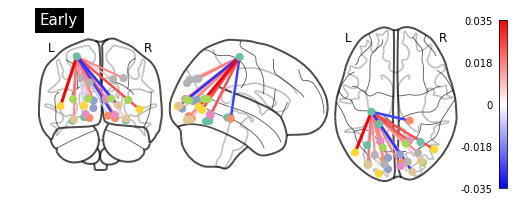

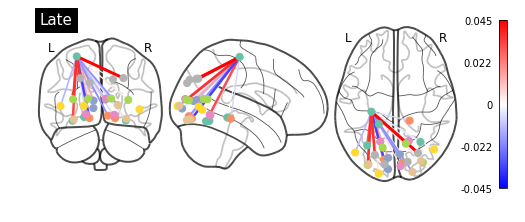

In [35]:
# LDA probs
draw_networks(lda_probs)

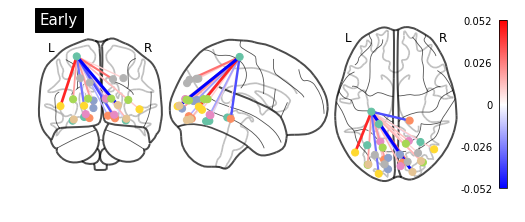

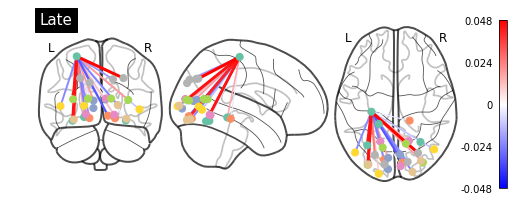

In [36]:
# LDA distance
draw_networks(lda_dists)

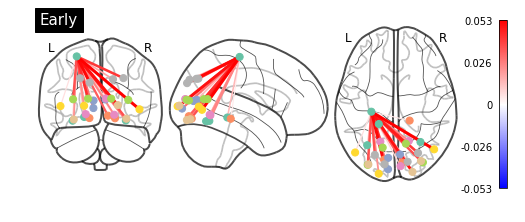

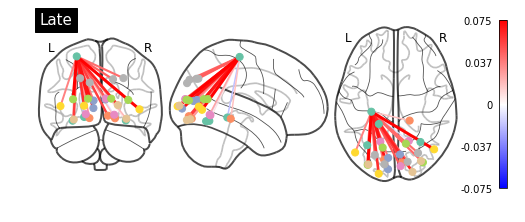

In [37]:
# SVC probs
draw_networks(svc_probs)

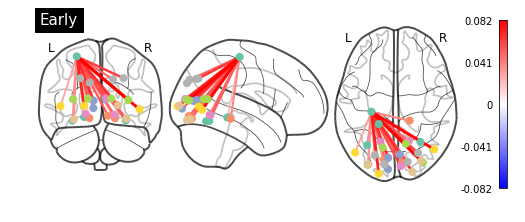

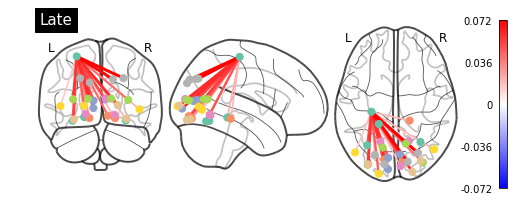

In [38]:
# SVC distance
draw_networks(svc_dists)

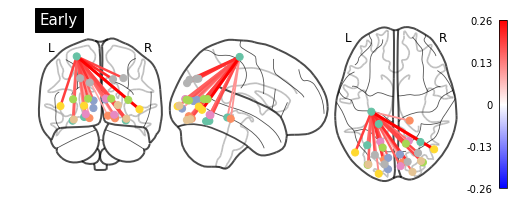

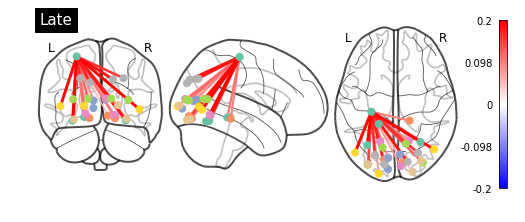

In [39]:
# correlation
draw_networks(corr_corrs)

In [32]:
df = pd.DataFrame(columns=['subj', 'roi_idx', 'roi_name', 'method', 'time', 'score'])

for dataset_name, dataset in [('LDA prob', lda_probs), ('LDA dist', lda_dists), 
                              ('SVC prob', svc_probs), ('SVC dist', svc_dists), ('Correlation', corr_corrs)]:
    early, late = calc_corr_coefficient(dataset)
    
    for time, corr_coef in [('Early', early), ('Late', late)]:
        for subj in subj_list:
            for roi_idx, roi_name in zip(roi_idxs, roi_names):
                df = df.append({
                        'subj': subj, 'roi_idx': roi_idx, 'roi_name': roi_name, 
                        'method': dataset_name, 'time': time, 'score': corr_coef[subj, roi_idx]}, 
                    ignore_index=True)

df.head()

,subj,roi_idx,roi_name,method,time,score
0,GA01,105,"Lt. fusiform gyrus (BA37, medioventral)",LDA prob,Early,-0.020000
1,GA01,106,"Rt. fusiform gyrus (BA37, medioventral)",LDA prob,Early,-0.039024
2,GA01,119,Lt. parahippocampal gyrus (area TH),LDA prob,Early,0.001545
3,GA01,120,Rt. parahippocampal gyrus (area TH),LDA prob,Early,0.120298
4,GA01,189,Lt. lingual gyrus (caudal),LDA prob,Early,-0.044335


/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


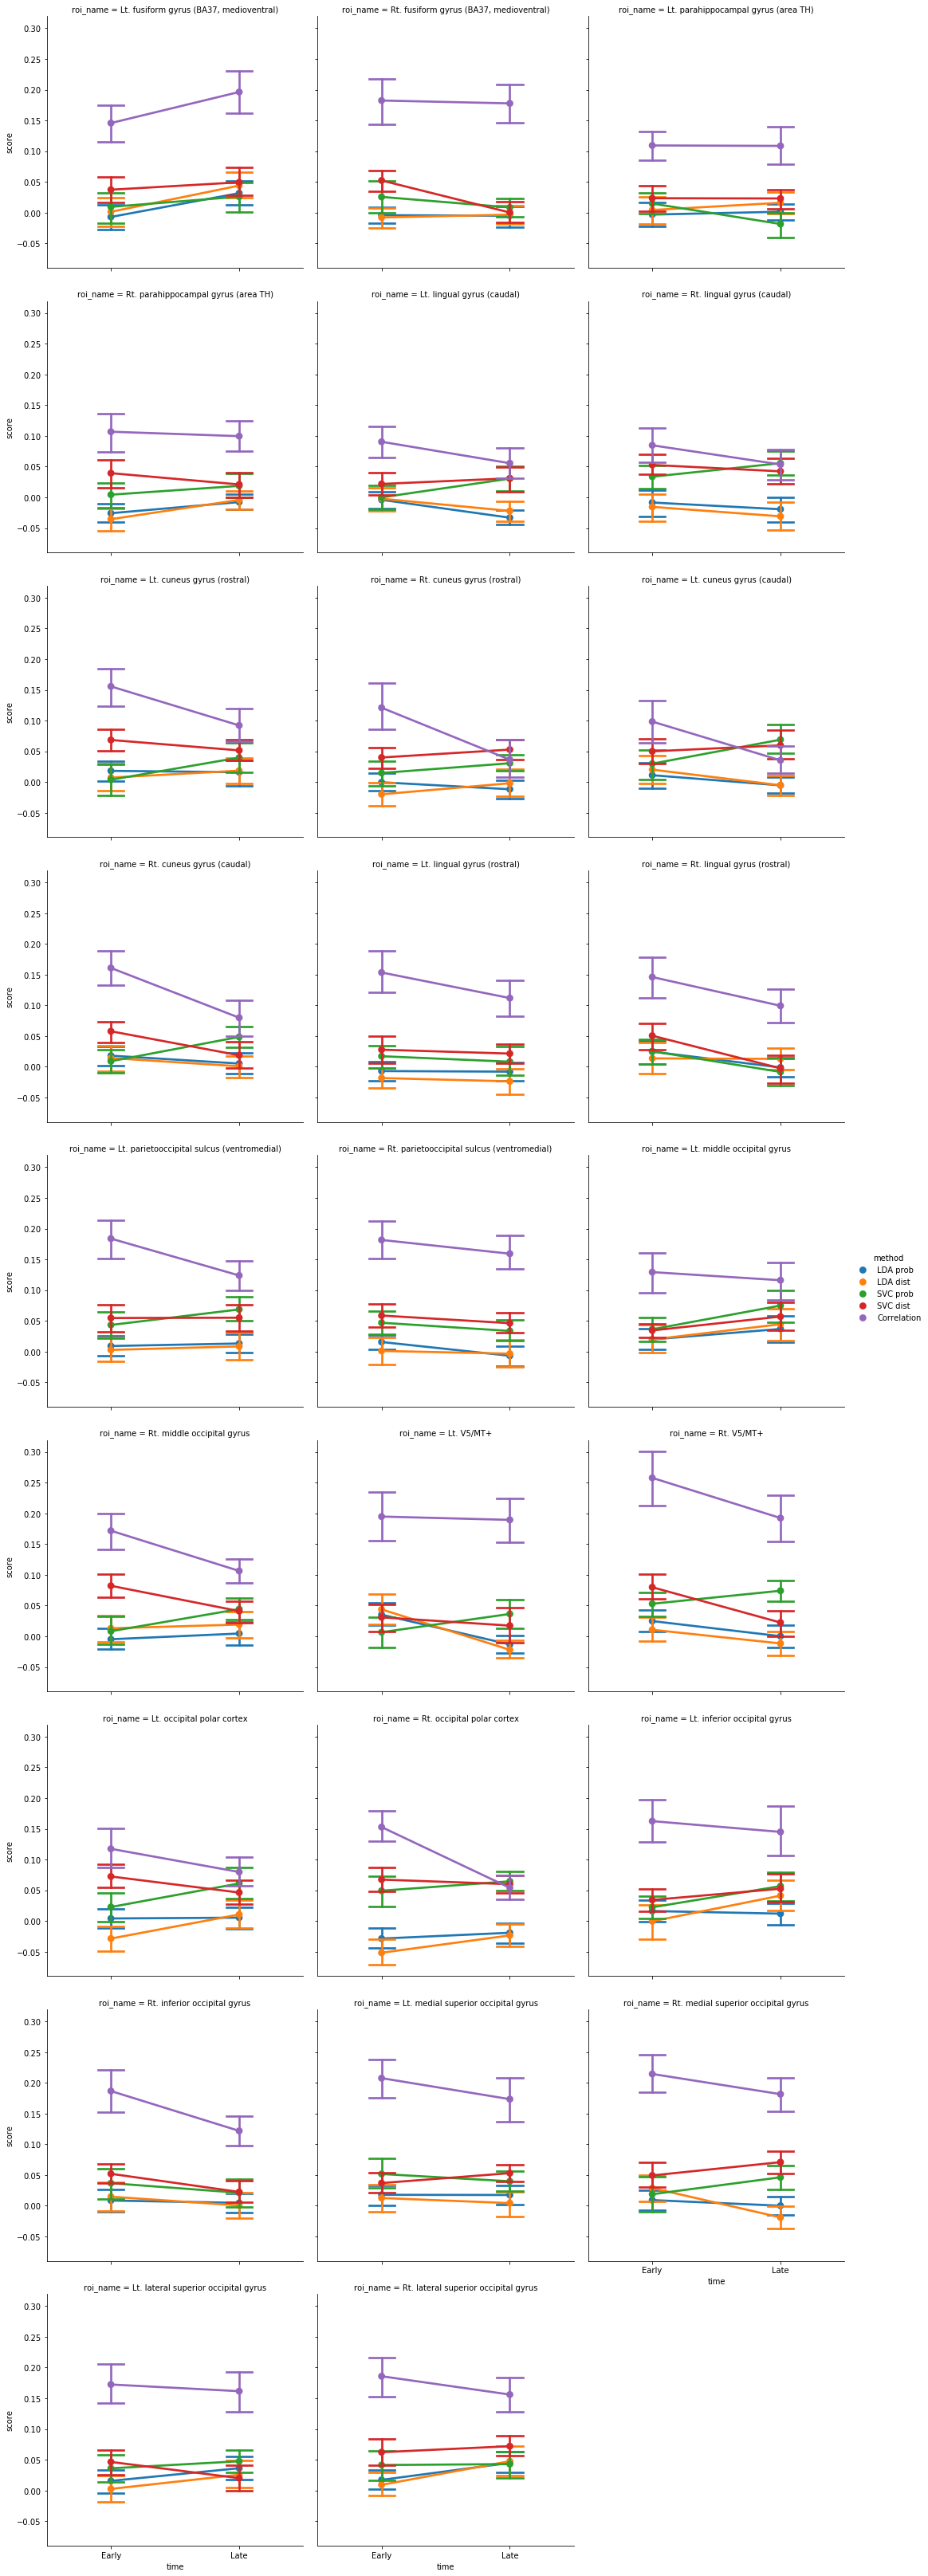

In [33]:
sns.catplot(data=df, x='time', y='score', hue='method', col='roi_name', capsize=.2, kind='point', ci=68, legend=True, col_wrap=3)

## References
- [1] Anzellotti, Stefano, and Marc N. Coutanche. "Beyond functional connectivity: investigating networks of multivariate representations." *Trends in cognitive sciences* 22.3(2018): 258-269.
- [2] https://stackoverflow.com/questions/32074239/sklearn-getting-distance-of-each-point-from-decision-boundary
- [3] Coutanche, M. N., & Thompson-Schill, S. L. (2013). Informational connectivity: identifying synchronized discriminability of multi-voxel patterns across the brain. *Frontiers in human neuroscience*, 7, 15.